In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
class ImageConv(nn.Sequential):
    def __init__(self):
        super().__init__(                                   # B 1   28  28
            nn.BatchNorm2d(num_features=1),
            nn.Conv2d(1, 64, 3, stride=1, padding=3),       # B 64  32  32  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),      # B 64  32  32
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 64  16  16
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),     # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),    # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 128 8   8
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),    # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),    # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 256 4   4
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),    # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),    # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 512 2   2
            nn.Dropout2d(0.2, inplace=True)
        )

In [69]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(                          # B 1   28  28
            nn.BatchNorm2d(num_features=1),
            nn.Conv2d(1, 64, 3, stride=1, padding=3),       # B 64  32  32  
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),      # B 64  32  32
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 64  16  16
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),     # B 128 16  16
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),    # B 128 16  16
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 128 8   8
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),    # B 256 8   8
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),    # B 256 8   8
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 256 4   4
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),    # B 512 4   4
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),    # B 512 4   4
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2, padding=0),           # B 512 2   2
            nn.Dropout2d(0.2, inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 512),              # B 512
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(512, 256),               # B 256
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(256, 1),                 # B 1
            nn.Sigmoid()
        )
    
    def forward(self, full_image):
        # full_image        B   28  28
        
        full_image = full_image.unsqueeze(1)    # B 1   28  28
        out = self.conv(full_image)             # B 512 2   2
        out = out.flatten(1)                    # B 2048
        out = self.fc(out)                      # B 1
        out = out.squeeze()                     # B
        return out


In [98]:
class Generator(nn.Module):
    def __init__(self, conv:nn.Module):
        super().__init__()

        self.conv = conv

        self.noise_fc = nn.Sequential(                                          # B 100
            nn.Linear(100, 1024),                                               # B 1024
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.dc = nn.Sequential(                                                # B 1024    2   1
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False),  # B 512     4   2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),                        # B 512     4   2
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),   # B 256     8   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),                        # B 256     8   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),   # B 128     16  8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),                        # B 128     16  8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),    # B 64      32  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),                          # B 64      30  14
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, 3, stride=1, padding=(0, 1)),                      # B 1       28  14
            nn.ReLU(inplace=True),
        )

    def forward(self, z, left):
        # z     B   100
        # left  B   28  14

        left = left.unsqueeze(1)                                                            # B 1   28  14

        with torch.no_grad():
            condition_features = self.conv(left)                                            # B 512 2   1
        condition_features = condition_features.flatten(1).unsqueeze(2)                     # B 1024    1

        noise_features = self.noise_fc(z).unsqueeze(2)                                      # B 1024    1

        dc_input = torch.cat((condition_features, noise_features), dim=2).unsqueeze(3)      # B 1024    2   1
        constructed = self.dc(dc_input)                                                     # B 1   28  14
        constructed = constructed.squeeze(1)                                                # B 28  14

        return constructed.clamp(0, 1)

In [5]:
def get_batches(X, y=None, batch_size=128, shuffle=True):
    if y is not None:
        assert X.shape[0] == y.shape[0]

    num_batches = int(np.ceil(X.shape[0] * 1.0 / batch_size))

    if shuffle:
        indices = np.random.permutation(X.shape[0])
        X = X[indices]
        if y is not None:
            y = y[indices]

    for batch in range(num_batches):
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X.shape[0])
        yield (batch, X[start:end], y[start:end]) if y is not None else (batch, X[start:end])

In [6]:
X, y = fetch_openml(name='mnist_784', return_X_y=True)

In [7]:
y = y.astype('int32')

In [8]:
X = X.reshape((X.shape[0], 28, 28)).astype('float32')
X.shape

(70000, 28, 28)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((50400, 28, 28), (14000, 28, 28), (5600, 28, 28)),
 ((50400,), (14000,), (5600,)))

### Pretrained Convolutional layer with a classifier

In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = ImageConv()

        self.decider = nn.Sequential(            # B 2048
            nn.Linear(2048, 512),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=-1)
        )
    
    def forward(self, b_x):
        # b_x   B   28  28
        b_x = b_x.unsqueeze(1)                  # B 1   28  28
        out = self.conv(b_x)                    # B 512 2   2
        out = out.flatten(1)                    # B 2048
        out = self.decider(out)                 # B 10
        return out

In [ ]:
def train_classifier(model, optimizer, X, y, batch_size):
    epoch_loss = 0
    epoch_accuracy = 0
    iter = 0

    model.train()
    for iter, b_X, b_y in get_batches(X, y, batch_size):
        prediction = model(torch.tensor(b_X, device='cuda'))

        loss = -1 * torch.mean(prediction[torch.arange(b_X.shape[0]), b_y])
        decision = prediction.argmax(dim=1)

        epoch_loss += float(loss)
        epoch_accuracy += (decision.cpu().numpy() == b_y).sum()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss /= (iter + 1)
    epoch_accuracy *= 100.0 / X.shape[0]

    return epoch_loss, epoch_accuracy

In [ ]:
def evaluate_classifier(model, X, y, batch_size):
    epoch_loss = 0
    epoch_accuracy = 0
    iter = 0

    with torch.no_grad():
        model.eval()
        for iter, b_X, b_y in get_batches(X, y, batch_size, shuffle=False):
            prediction = model(torch.tensor(b_X, device='cuda'))

            loss = -1 * torch.mean(prediction[torch.arange(b_X.shape[0]), b_y])
            decision = prediction.argmax(dim=1)

            epoch_loss += float(loss)
            epoch_accuracy += (decision.cpu().numpy() == b_y).sum()
        
    epoch_loss /= (iter + 1)
    epoch_accuracy *= 100.0 / X.shape[0]

    return epoch_loss, epoch_accuracy

In [ ]:
classifier = MNISTClassifier().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

In [ ]:
batch_size = 256
epochs = 40

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

best_val_acc = 0

for e in range(epochs):

    start_time = time()

    epoch_train_loss, epoch_train_accuracy = train_classifier(classifier, optimizer, X_train, y_train, batch_size)
    epoch_val_loss, epoch_val_accuracy = evaluate_classifier(classifier, X_val, y_val, batch_size)

    end_time = time()

    if epoch_val_accuracy > best_val_acc:
        best_val_acc = epoch_val_accuracy
        torch.save(classifier.conv.state_dict(), 'mnist-conv-model.pt')
    
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s - Train loss: {epoch_train_loss:.2e} - Train accuracy: {epoch_train_accuracy:.2f} - Val loss: {epoch_val_loss:.2e} - Val accuracy: {epoch_val_accuracy:.2f}')

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)   

Epoch   1 finished in 20.94s - Train loss: 4.18e-01 - Train accuracy: 86.70 - Val loss: 5.59e-02 - Val accuracy: 98.25
Epoch   2 finished in 21.49s - Train loss: 5.56e-02 - Train accuracy: 98.34 - Val loss: 3.59e-02 - Val accuracy: 98.84
Epoch   3 finished in 20.57s - Train loss: 3.87e-02 - Train accuracy: 98.84 - Val loss: 2.89e-02 - Val accuracy: 99.09
Epoch   4 finished in 20.31s - Train loss: 3.00e-02 - Train accuracy: 99.07 - Val loss: 2.49e-02 - Val accuracy: 99.21
Epoch   5 finished in 20.58s - Train loss: 2.39e-02 - Train accuracy: 99.26 - Val loss: 2.72e-02 - Val accuracy: 99.20
Epoch   6 finished in 20.83s - Train loss: 1.95e-02 - Train accuracy: 99.37 - Val loss: 2.60e-02 - Val accuracy: 99.20
Epoch   7 finished in 20.63s - Train loss: 1.62e-02 - Train accuracy: 99.51 - Val loss: 2.53e-02 - Val accuracy: 99.36
Epoch   8 finished in 20.55s - Train loss: 1.48e-02 - Train accuracy: 99.54 - Val loss: 2.59e-02 - Val accuracy: 99.38
Epoch   9 finished in 20.54s - Train loss: 1.29e

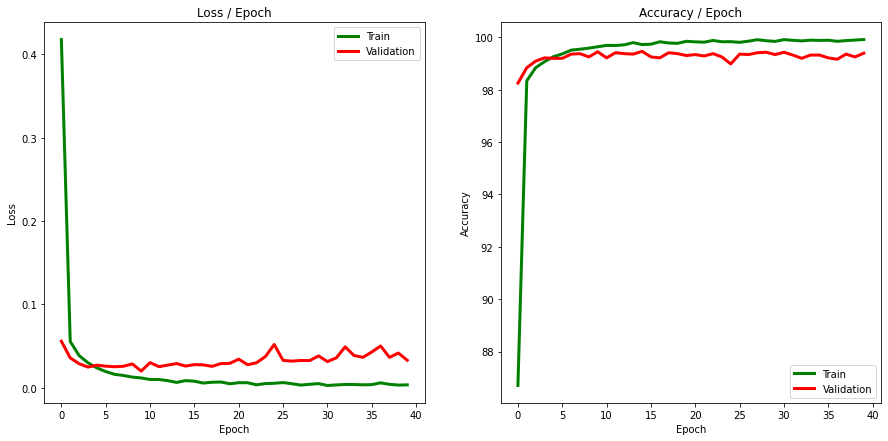

In [ ]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_accuracy, label='Train', color='green', linewidth=3)
plt.plot(val_accuracy, label='Validation', color='red', linewidth=3)


plt.legend()

In [ ]:
test_loss, test_accuracy = evaluate_classifier(classifier, X_test, y_test, batch_size)
print(f'Test loss: {test_loss:.4f} - Accuracy: {test_accuracy:.2f}')

Test loss: 0.0343 - Accuracy: 99.42


### Pretrained Convolutional layer with an Autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ImageConv()

        self.decoder = nn.Sequential(                                           # B 512 2   2
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),   # B 256 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),                        # B 256 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),   # B 128 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),                        # B 128 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),    # B 64  16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),                          # B 64  16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),     # B 64  32  32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, 3, stride=1, padding=0),                          # B 64  30  30
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, stride=1, padding=0),                            # B 1   28  28
            nn.ReLU(inplace=True)
        )
    
    def forward(self, b_x):
        # b_x   B   28  28

        b_x = b_x.unsqueeze(1)              # B 1   28  28
        encoded = self.encoder(b_x)         # B 512 2   2
        decoded = self.decoder(encoded)     # B 1   28  28
        decoded = decoded.squeeze(1)

        return decoded

In [11]:
def train_autoencoder(model, optimizer, X, batch_size):
    epoch_loss = 0
    iter = 0

    model.train()
    for iter, b_X in get_batches(X, batch_size=batch_size):
        images = torch.tensor(b_X, device='cuda')
        prediction = model(images)

        loss = F.mse_loss(prediction, images)

        epoch_loss += float(loss)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if (iter + 1) % 50 == 0:
            print(f'[Train] Iteration {iter + 1:3d} - loss: {epoch_loss / (iter + 1):.2e}')
    
    epoch_loss /= (iter + 1)

    return epoch_loss

In [25]:
def evaluate_autoencoder(model, X, batch_size, return_predictions=False):
    epoch_loss = 0
    iter = 0
    predictions = []

    with torch.no_grad():
        model.eval()
        for iter, b_X in get_batches(X, batch_size=batch_size, shuffle=False):
            images = torch.tensor(b_X, device='cuda')
            prediction = model(images)
            predictions.append(prediction.cpu().numpy())

            loss = F.mse_loss(prediction, images)

            epoch_loss += float(loss)

            if (iter + 1) % 50 == 0:
                print(f'[Valid] Iteration {iter + 1:3d} - loss: {epoch_loss / (iter + 1):.2e}')
        
    epoch_loss /= (iter + 1)
    if return_predictions:
        return np.concatenate(predictions, axis=0), epoch_loss

    return epoch_loss

In [13]:
images_train = X_train / 255
images_val = X_val / 255
images_test = X_test / 255

In [14]:
autoencoder = Autoencoder().cuda()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

In [16]:
batch_size = 256
epochs = 200

train_loss = []
val_loss = []

best_val_loss = float('inf')

for e in range(epochs):

    start_time = time()

    epoch_train_loss = train_autoencoder(autoencoder, optimizer, images_train, batch_size)
    epoch_val_loss = evaluate_autoencoder(autoencoder, images_val, batch_size)

    end_time = time()

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(autoencoder.encoder.state_dict(), 'drive/My Drive/mnist-autoencoder-conv-model.pt')
    
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s - Train loss: {epoch_train_loss:.2e} - Val loss: {epoch_val_loss:.2e}')

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

[Train] Iteration  50 - loss: 7.92e-02
[Train] Iteration 100 - loss: 6.16e-02
[Train] Iteration 150 - loss: 5.12e-02
Epoch   1 finished in 31.71s - Train loss: 4.46e-02 - Val loss: 1.91e-02
[Train] Iteration  50 - loss: 1.93e-02
[Train] Iteration 100 - loss: 1.81e-02
[Train] Iteration 150 - loss: 1.71e-02
Epoch   2 finished in 31.97s - Train loss: 1.63e-02 - Val loss: 1.19e-02
[Train] Iteration  50 - loss: 1.29e-02
[Train] Iteration 100 - loss: 1.24e-02
[Train] Iteration 150 - loss: 1.21e-02
Epoch   3 finished in 32.34s - Train loss: 1.17e-02 - Val loss: 8.86e-03
[Train] Iteration  50 - loss: 1.05e-02
[Train] Iteration 100 - loss: 1.02e-02
[Train] Iteration 150 - loss: 9.94e-03
Epoch   4 finished in 32.81s - Train loss: 9.77e-03 - Val loss: 8.34e-03
[Train] Iteration  50 - loss: 8.84e-03
[Train] Iteration 100 - loss: 8.76e-03
[Train] Iteration 150 - loss: 8.64e-03
Epoch   5 finished in 32.99s - Train loss: 8.53e-03 - Val loss: 7.10e-03
[Train] Iteration  50 - loss: 8.03e-03
[Train] Ite

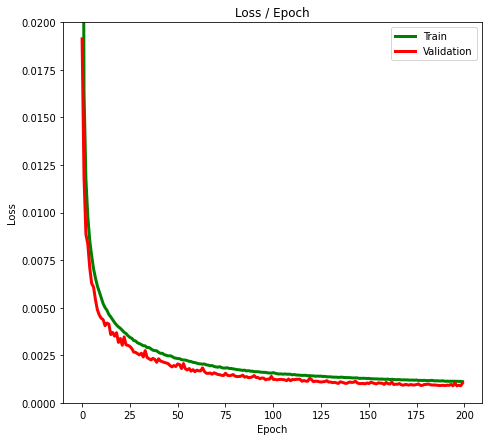

In [20]:
fig = plt.figure(figsize=(7.5, 7))

# loss
ax = fig.add_subplot(111)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)
plt.ylim((0, 2e-2))


plt.legend()

In [26]:
predictions, test_loss = evaluate_autoencoder(autoencoder, images_test, batch_size=batch_size, return_predictions=True)
test_loss

[Valid] Iteration  50 - loss: 1.04e-03


0.0010420581728050654

In [27]:
def draw(images, texts, columns=1, rows=1):
    fig = plt.figure(figsize=(2 * columns, 2 * rows))

    for i in range(columns * rows):
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.set_title(texts[i])
        ax.set_aspect('equal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(images[i].reshape((28, 28)))

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.show()

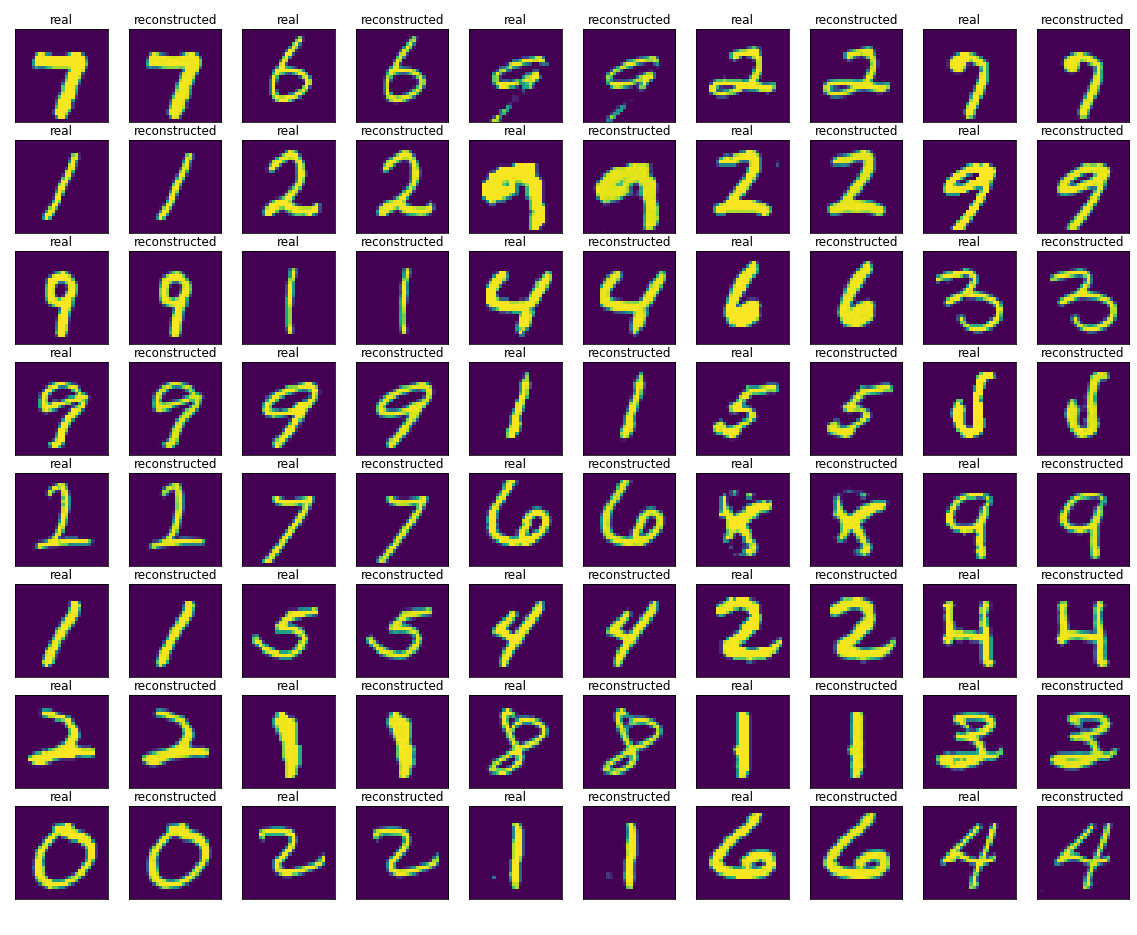

In [28]:
rows = 8
columns = 10
indices = np.random.choice(np.arange(len(images_test)), size=rows * columns // 2)
images = np.zeros((rows * columns // 2, 2, 28, 28))
images[:,0] = images_test[indices].reshape(rows * columns // 2, 28, 28)
images[:,1] = predictions[indices].reshape(rows * columns // 2, 28, 28)
images = images.reshape(rows * columns, 28, 28) * 255

texts = np.zeros((rows * columns // 2, 2), dtype=object)
texts[:,0] = np.array(['real' for _ in range(rows * columns // 2)])
texts[:,1] = np.array(['reconstructed' for _ in range(rows * columns // 2)])
texts = texts.reshape(rows * columns)

draw(images, texts, columns, rows)

### Train a Conditional DCGAN for constructing right half of an image given the left half of it

In [33]:
def generator_train_step(generator, discriminator, b_images, g_optimizer, criterion):
    g_optimizer.zero_grad()
    B = b_images.shape[0]

    z = torch.randn(B, 100, device='cuda')
    cuda_images = torch.tensor(b_images, device='cuda')

    left = cuda_images[:, :, :14]                                       # B 28  14
    right = cuda_images[:, :, 14:]                                      # B 28  14

    fake_right = generator(z, left)                                     # B 28  14
    validity = discriminator(torch.cat((left, fake_right), dim=2))      # B

    g_loss = criterion(validity, torch.ones(B, device='cuda'))
    g_loss.backward()
    g_optimizer.step()
    return float(g_loss)

In [79]:
def discriminator_train_step(generator, discriminator, b_images, d_optimizer, criterion):
    d_optimizer.zero_grad()
    B = b_images.shape[0]

    real_images = torch.tensor(b_images[:B//2], device='cuda')                  # B/2   28  28
    fake_images = torch.tensor(b_images[B//2:], device='cuda')                  # B/2   28  28

    z = torch.randn(fake_images.shape[0], 100, device='cuda')
    left = fake_images[:, :, :14]
    with torch.no_grad():
        fake_right = generator(z, left).detach()                                # B/2   28  14
    generated_images = torch.cat((left, fake_right), dim=2)                     # B/2   28  28

    discriminator_inputs = torch.cat((real_images, generated_images), dim=0)    # B     28  28
    expected = torch.cat((torch.ones(real_images.shape[0], device='cuda'), torch.zeros(generated_images.shape[0], device='cuda')), dim=0)   # B

    validity = discriminator(discriminator_inputs)                              # B
    d_loss = criterion(validity, expected)

    d_loss.backward()
    d_optimizer.step()

    return float(d_loss)


In [99]:
def train_GAN(generator, discriminator, images, g_optimizer, d_optimizer, criterion, batch_size, discriminator_step):
    epoch_g_loss = 0
    g_count = 0
    epoch_d_loss = 0
    d_count = 0
    
    generator.train()
    discriminator.train()

    for iter, b_images in get_batches(images, batch_size=batch_size):
        if (iter + 1) % discriminator_step == 0:
            d_loss = discriminator_train_step(generator, discriminator, b_images, d_optimizer, criterion)
            d_count += 1
            epoch_d_loss += d_loss
        else:
            g_loss = generator_train_step(generator, discriminator, b_images, g_optimizer, criterion)
            g_count += 1
            epoch_g_loss += g_loss
    
    epoch_g_loss /= g_count * 1.0
    epoch_d_loss /= d_count * 1.0

    return epoch_g_loss, epoch_d_loss

In [105]:
def display_GAN(generator, images, columns, rows):
    with torch.no_grad():
        generator.eval()
        for _, batch in get_batches(images, batch_size=columns * rows):
            z = torch.randn(columns * rows, 100, device='cuda')
            batch_images = torch.tensor(batch, device='cuda')
            left = batch_images[:, :, :14]
            right = generator(z, left)
            generated_images = torch.cat((left, right), dim=2).cpu().numpy() * 255      # row*col   28  28

            images_to_show = np.zeros((rows * columns, 2, 28, 28))
            images_to_show[:,0] = batch
            images_to_show[:,1] = generated_images
            images_to_show = images_to_show.reshape(rows * columns * 2, 28, 28)

            texts = np.zeros((rows * columns, 2), dtype=object)
            texts[:,0] = np.array(['real' for _ in range(rows * columns)])
            texts[:,1] = np.array(['generated' for _ in range(rows * columns)])
            texts = texts.reshape(rows * columns * 2)

            draw(images_to_show, texts, columns * 2, rows)
            break

In [48]:
imageconv = autoencoder.encoder

In [100]:
generator = Generator(imageconv).cuda()
discriminator = Discriminator().cuda()

In [101]:
discriminator.conv.load_state_dict(torch.load('drive/My Drive/mnist-autoencoder-conv-model.pt'))

<All keys matched successfully>

In [102]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

Epoch   1 finished in 52.65s - Generator loss: 1.12e+00 - Discriminator loss: 4.47e-01


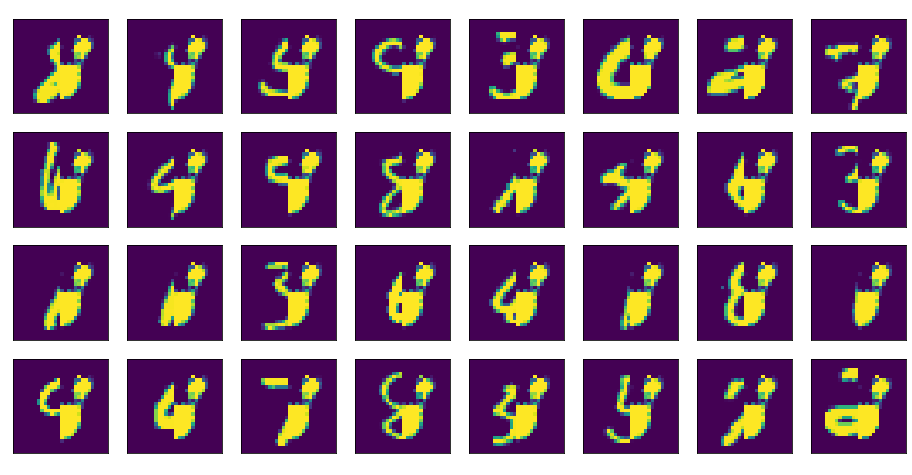

Epoch   2 finished in 53.64s - Generator loss: 1.41e+00 - Discriminator loss: 3.65e-01
Epoch   3 finished in 53.91s - Generator loss: 2.10e+00 - Discriminator loss: 1.93e-01


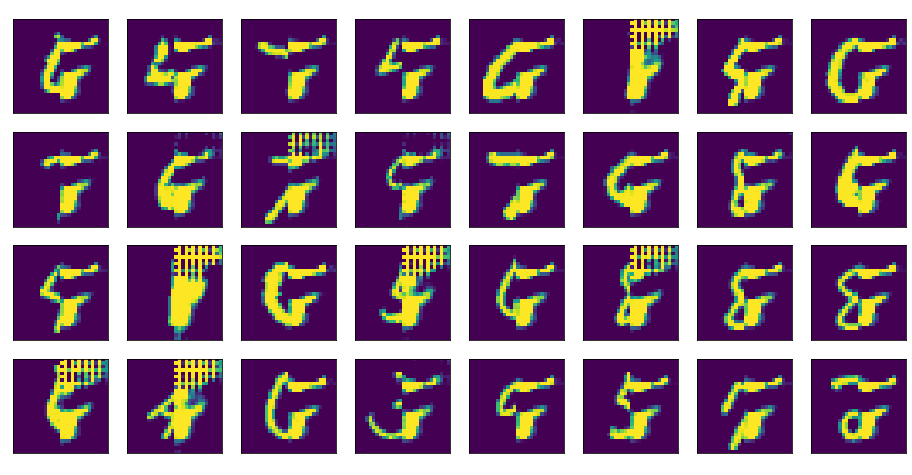

Epoch   4 finished in 53.93s - Generator loss: 1.91e+00 - Discriminator loss: 2.18e-01
Epoch   5 finished in 53.83s - Generator loss: 1.75e+00 - Discriminator loss: 2.00e-01


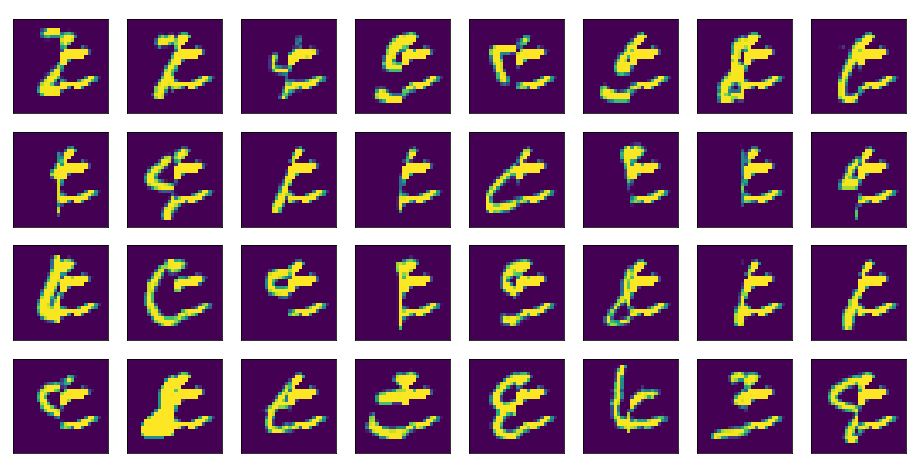

Epoch   6 finished in 53.95s - Generator loss: 1.64e+00 - Discriminator loss: 2.94e-01
Epoch   7 finished in 53.79s - Generator loss: 9.03e-01 - Discriminator loss: 6.44e-01


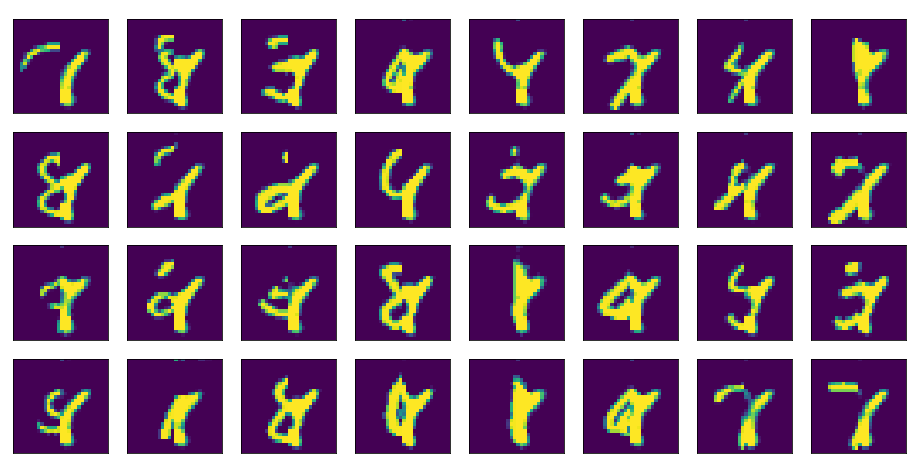

Epoch   8 finished in 53.91s - Generator loss: 1.79e+00 - Discriminator loss: 4.30e-01
Epoch   9 finished in 53.83s - Generator loss: 8.96e-01 - Discriminator loss: 5.58e-01


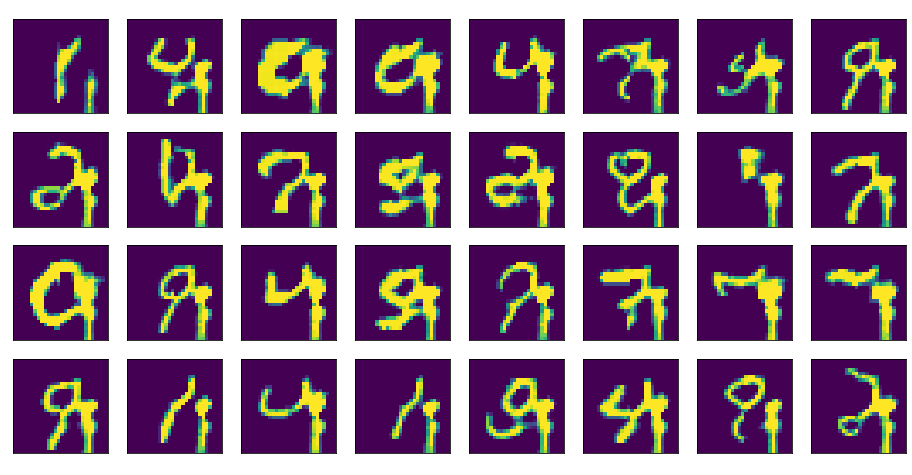

Epoch  10 finished in 53.82s - Generator loss: 1.83e+00 - Discriminator loss: 2.27e-01
Epoch  11 finished in 53.79s - Generator loss: 2.23e+00 - Discriminator loss: 1.27e-01


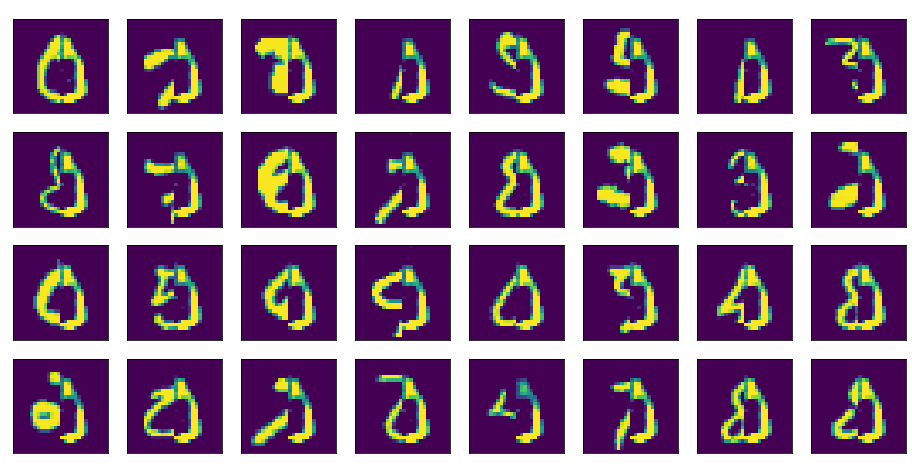

Epoch  12 finished in 53.93s - Generator loss: 1.53e+00 - Discriminator loss: 1.17e-01
Epoch  13 finished in 53.83s - Generator loss: 9.72e-01 - Discriminator loss: 6.15e-01


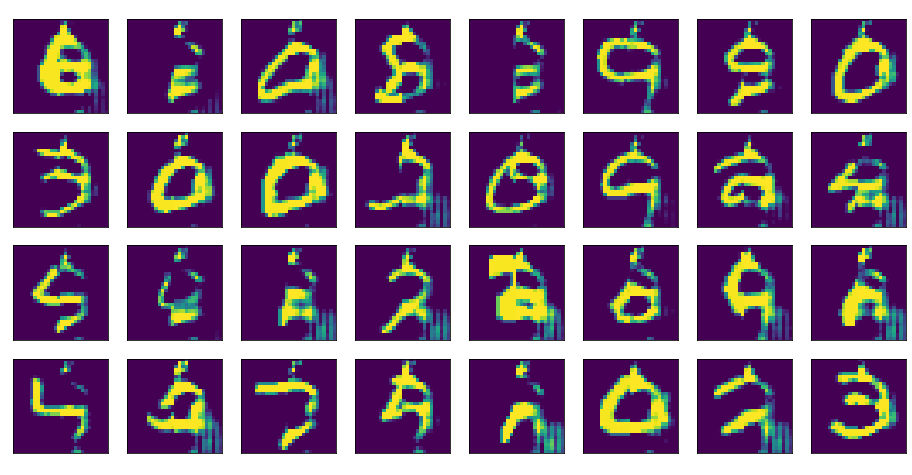

Epoch  14 finished in 53.84s - Generator loss: 2.04e+00 - Discriminator loss: 9.53e-02
Epoch  15 finished in 53.86s - Generator loss: 1.93e+00 - Discriminator loss: 2.14e-01


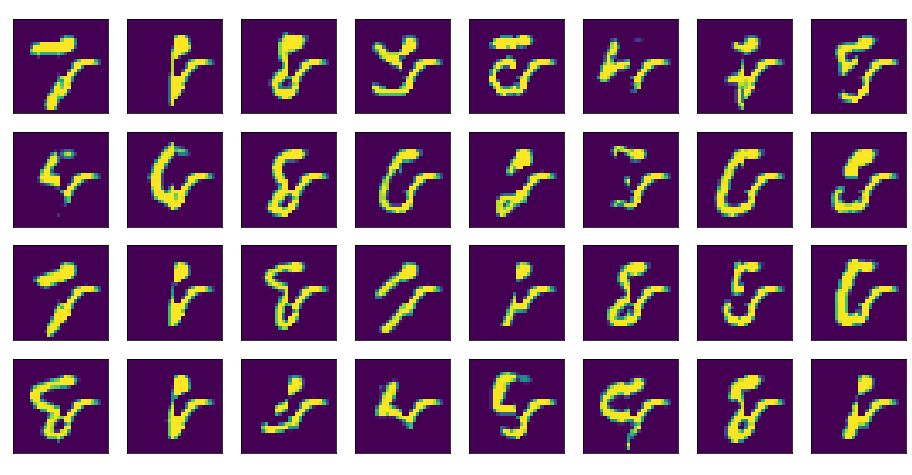

Epoch  16 finished in 53.82s - Generator loss: 1.41e+00 - Discriminator loss: 3.95e-01
Epoch  17 finished in 53.94s - Generator loss: 1.96e+00 - Discriminator loss: 2.44e-01


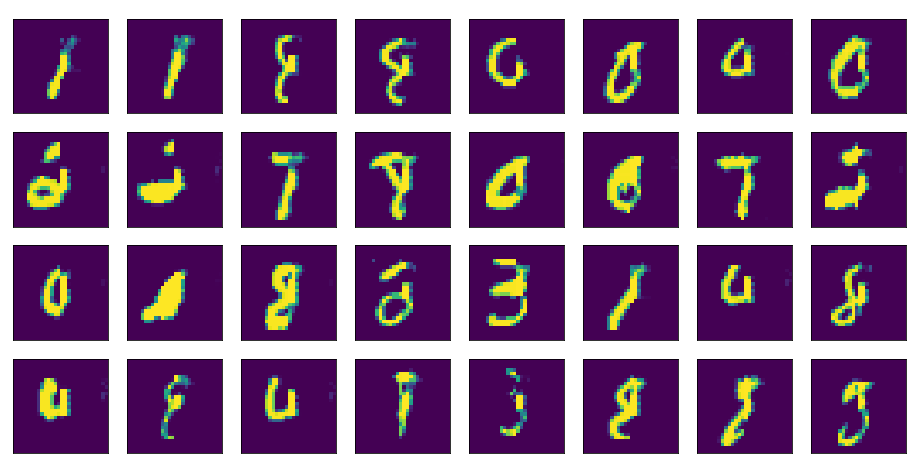

Epoch  18 finished in 53.79s - Generator loss: 9.81e-01 - Discriminator loss: 5.97e-01
Epoch  19 finished in 53.84s - Generator loss: 1.02e+00 - Discriminator loss: 5.52e-01


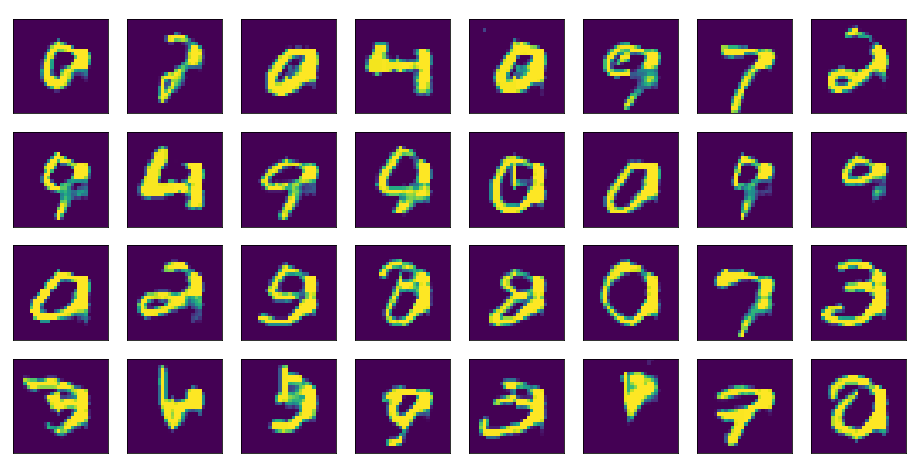

Epoch  20 finished in 53.94s - Generator loss: 9.76e-01 - Discriminator loss: 5.08e-01
Epoch  21 finished in 53.74s - Generator loss: 9.73e-01 - Discriminator loss: 6.34e-01


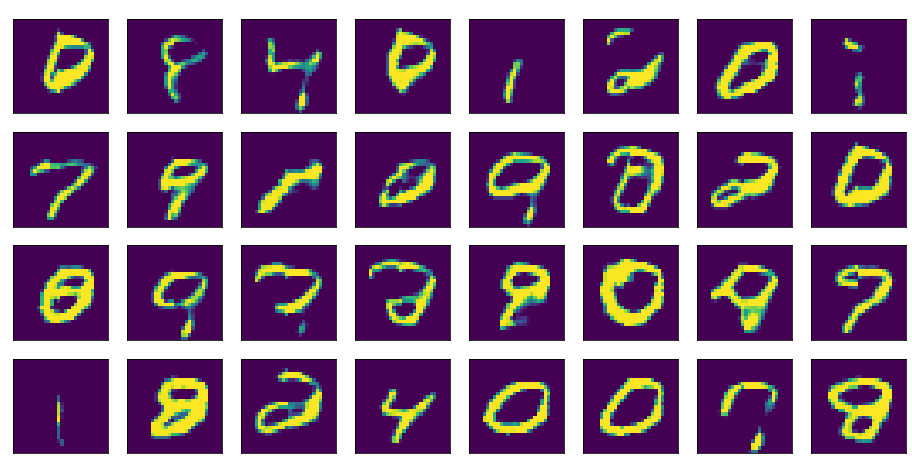

Epoch  22 finished in 53.83s - Generator loss: 9.35e-01 - Discriminator loss: 6.07e-01
Epoch  23 finished in 53.91s - Generator loss: 8.53e-01 - Discriminator loss: 6.49e-01


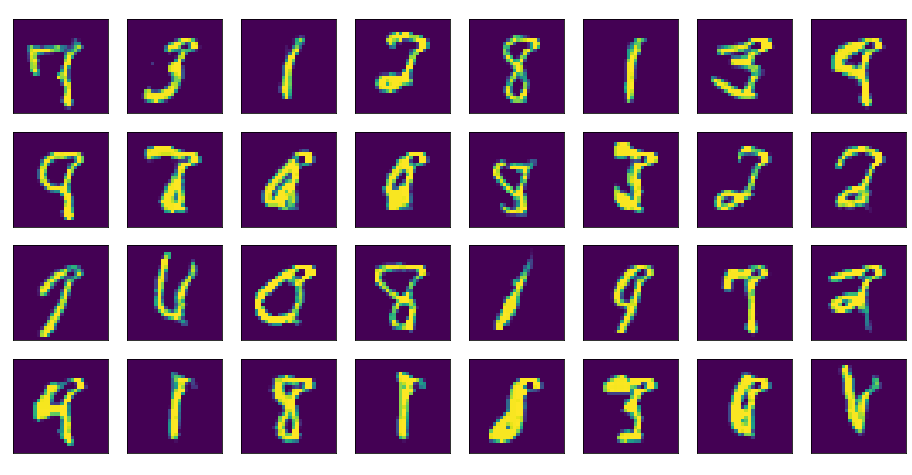

Epoch  24 finished in 53.89s - Generator loss: 9.65e-01 - Discriminator loss: 5.70e-01
Epoch  25 finished in 53.82s - Generator loss: 1.03e+00 - Discriminator loss: 5.73e-01


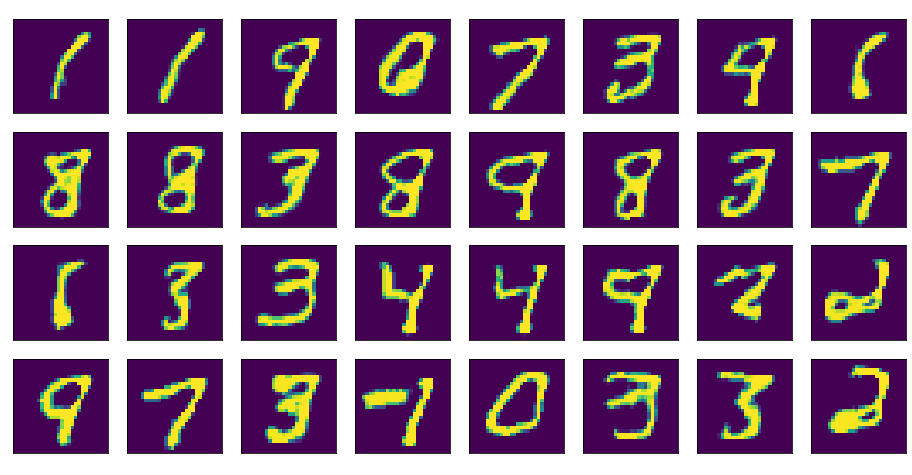

Epoch  26 finished in 53.91s - Generator loss: 8.97e-01 - Discriminator loss: 6.22e-01
Epoch  27 finished in 53.75s - Generator loss: 1.03e+00 - Discriminator loss: 5.86e-01


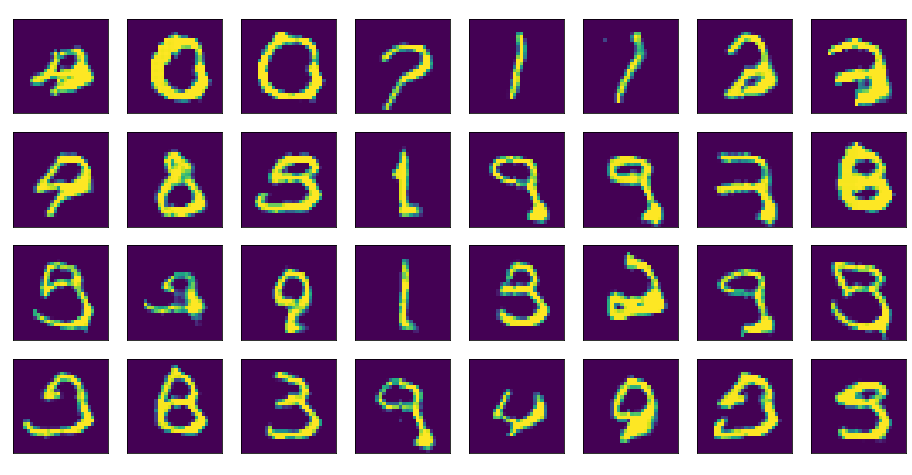

Epoch  28 finished in 53.83s - Generator loss: 8.33e-01 - Discriminator loss: 6.38e-01
Epoch  29 finished in 53.88s - Generator loss: 9.53e-01 - Discriminator loss: 5.93e-01


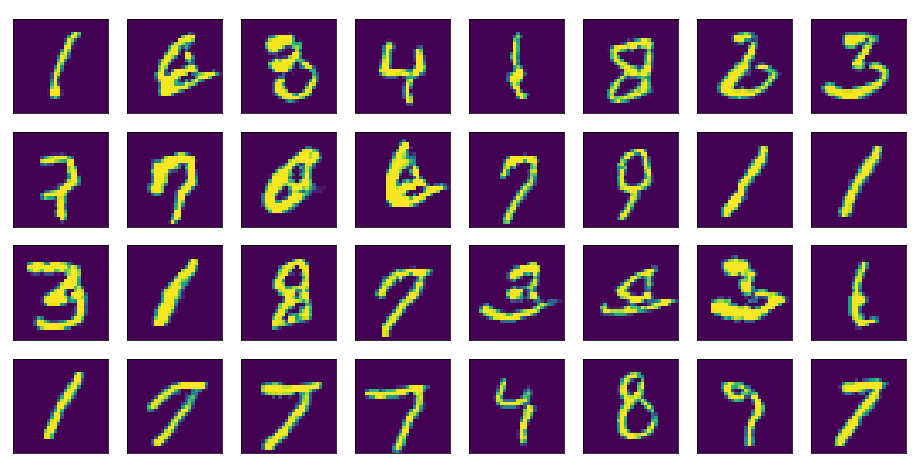

Epoch  30 finished in 53.79s - Generator loss: 1.07e+00 - Discriminator loss: 5.35e-01


In [103]:
batch_size = 256
epochs = 30
display_step = 2
discriminator_step = 4

g_loss = []
d_loss = []
best_loss = float('inf')

for e in range(epochs):

    start_time = time()

    epoch_g_loss, epoch_d_loss = train_GAN(generator, discriminator, images_train, g_optimizer, d_optimizer, criterion, batch_size, discriminator_step)
    
    end_time = time()

    if np.mean((epoch_g_loss, epoch_d_loss)) < best_loss:
        best_loss = np.mean((epoch_g_loss, epoch_d_loss))
        torch.save(autoencoder.encoder.state_dict(), 'drive/My Drive/gan-model.pt')
    
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s - Generator loss: {epoch_g_loss:.2e} - Discriminator loss: {epoch_d_loss:.2e}')

    g_loss.append(epoch_g_loss)
    d_loss.append(epoch_d_loss)

    if e % display_step == 0:
        display_GAN(generator, images_val, 8, 4)

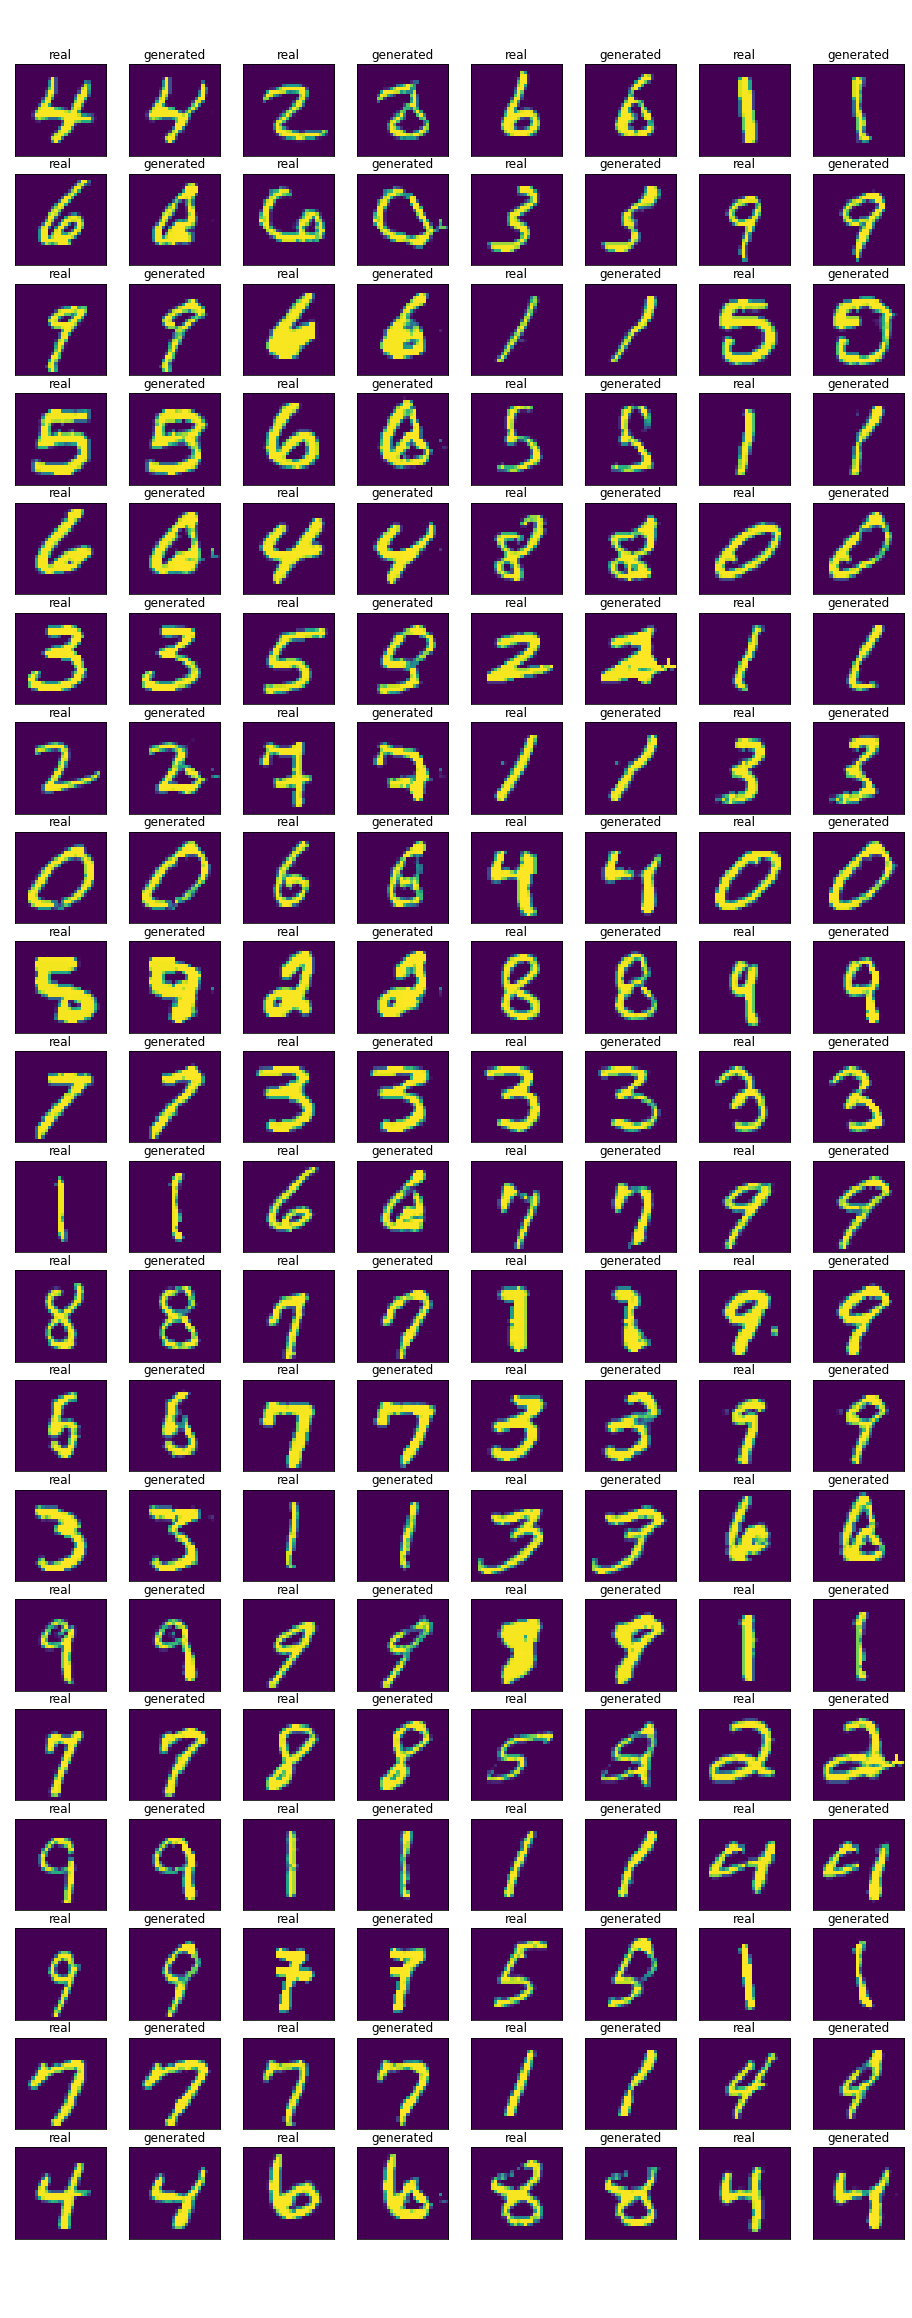

In [106]:
display_GAN(generator, images_test, 4, 20)